# Science4Cast
### A Machine Learning Challenge in the Science Of Science

In this notebook you will learn the following:

1. [How to read the data](#reading)
2. [Visualizing the data](#visualizing)
3. [Creating historic training data](#train)
4. [Training a baseline model (incl. features, training)](#baseline)
5. [Computing the metric: Area Under the Curve (AUC) ROC](#metric)
6. [Evaluating Testset for Competition](#testset)
7. [How to submit](#submit)

### Mini-Summary
In the competition you get
- full_dynamic_graph_sparse: a dynamic graph (list of edges and their creation date) until a time t1.
- unconnected_vertex_pairs: a list of 1,000,000 vertex pairs that are unconnected by time t1.

**Your task in the competition** is to predict which edges of unconnected_vertex_pairs will form until a time t2. Specifically, you sort the list of potential edges in unconnected_vertex_pairs from most likely to most unlikely. The result will be computed via the [AUC of the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

In [ ]:
%%capture
!pip install pytorch-lightning

In [ ]:
%pip install -q stellargraph[demos]==1.2.1

from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/My Drive/science4cast"

     |████████████████████████████████| 435 kB 5.0 MB/s 
     |████████████████████████████████| 407 kB 41.1 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from math import isclose
from scipy import sparse
import networkx as nx
import numpy as np
import pickle
import pandas as pd
import random
import time
from datetime import date
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import stellargraph as sg
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter

import torch
import torch.nn as nn

# Helpers

In [ ]:
def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    print(years)
    day_origin = date(1990,1,1)
    
    days_curr = (date(year_start,12,31)-day_origin).days
    days_later = (date(year_start+years_delta,12,31)-day_origin).days

    all_G = []

    for days in [days_later, days_curr]:
      all_edges=full_graph[full_graph[:,2]<=days]
      print('    num of edges: ', len(all_edges))
      adj_mat_sparse = sparse.csr_matrix((np.ones(len(all_edges)), (all_edges[:,0], all_edges[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
      all_G.append(nx.from_scipy_sparse_matrix(adj_mat_sparse, parallel_edges=False, create_using=None, edge_attribute='weight'))

    all_degs=np.array(adj_mat_sparse.sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    ## get positive examples
    all_edges_after = full_graph[(days_curr<full_graph[:,2]) & (full_graph[:,2]<=days_later)]
    print(len(all_edges_after))
    all_edges_after = all_edges_after[np.all(np.isin(all_edges_after[:,:2], vertex_large_degs), axis=1)]
    print(len(all_edges_after))

    ## get negative  examples
    unconnected_vertex_pairs=[]

    while len(unconnected_vertex_pairs) < max(edges_used, len(all_edges_after)):        
        v1,v2=np.random.choice(vertex_large_degs, 2)

        if (v1!=v2) and (not all_G[0].has_edge(v1,v2)) and (not all_G[1].has_edge(v1,v2)):
            unconnected_vertex_pairs.append((v1,v2))

    unconnected_vertex_pairs_solution=np.array([1]*len(all_edges_after)+[0]*len(unconnected_vertex_pairs))        
    unconnected_vertex_pairs=np.vstack((all_edges_after[:, :2], np.array(unconnected_vertex_pairs)))
  
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
      
    return np.array(all_edges), unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10

def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection != 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}
   
    return d, Z, tform

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, embedding, binary_operator):
    return binary_operator(embedding[link_examples[:,0]], embedding[link_examples[:,1]])

# 2. training classifier
def train_link_prediction_model(link_examples, link_labels, get_embedding, binary_operator):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=5, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(clf, link_examples_test, link_labels_test, get_embedding, binary_operator):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

def operator_concat(u,v):
    return np.hstack((u,v))


def run_link_prediction(binary_operator, embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
        "embedding": embedding_train,
    }

#binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]
binary_operators = [operator_l2]

<a id='reading'></a>
# 1. How to read the data

First, get the data from the [IARAI cloud](https://cloud.iarai.ac.at/index.php/s/iTx3bXgMdwsngPn). It contains three files:
- **TrainSet2014_3.pkl:** (33 MB) Semantic network until 2014, and list of unconnected vertex-pairs that can be predicted for training the neural network.
- **TrainSet2014_3_solution.pkl**: (0.5 MB) Solution of whether the unconnected vertex pair from 2014 has been connected by 2017.
- **CompetitionSet2017_3.pkl**: (95 MB) Semantic network until 2017, and list of unconnected vertex-pairs that should be predicted for the evaluation.

Afterwards we can read *TrainSet2014_3.pkl* using pickle.

In [ ]:
NUM_OF_VERTICES=64719 # number of vertices of the semantic net
DRIVE_PATH = "/content/drive/My Drive/science4cast"
data_source = os.path.join(DRIVE_PATH, 'competition_data/CompetitionSet2017_3.pkl')
#data_source = os.path.join(DRIVE_PATH, 'TrainSet2014_3.pkl')
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( data_source, "rb" ) )

print(data_source+' has '+str(len(full_dynamic_graph_sparse))+' edges between a total of '+str(NUM_OF_VERTICES)+ ' vertices.\n\n')
print('The goal is to predict which of '+str(len(unconnected_vertex_pairs))+' unconnectedvertex-pairs\nin unconnected_vertex_pairs will be connected until '+str(year_start+years_delta)+'.')


/content/drive/My Drive/science4cast/competition_data/CompetitionSet2017_3.pkl has 7652945 edges between a total of 64719 vertices.


The goal is to predict which of 1000000 unconnectedvertex-pairs
in unconnected_vertex_pairs will be connected until 2020.


In [ ]:
print(year_start)
year_start = 1994

2017


 - **full_dynamic_graph_sparse:** The entire semantic network until 2014 or 2017. It is a numpy array, each entry describes an edge in the semantic network. Each edge is described by three numbers [v1, v2, t], where the edge is formed at time t between vertices v1 and v2. t is measured in days since the 1.1.1990.

- **unconnected_vertex_pairs:** This is a list of vertex pairs v1,v2 with deg(v1)>=10, deg(v2)>=10, and no edge exists in the year 2014. The question that the neural network needs to solve: Will an edge form? It does not contain all unconnected vertices, but a random subset.


- **year_start:** year_start=2014


- **years_delta:** years_delta=3

The first and second number stand are indices of a vertex, the 3rd number stands for a time stamp (in days since 1.1.1990). 

For example, the first entry, edge #466956 between vertex 35266 and 36996 has been formed 7758 days after the 1.1.1990. Each of the 64719 vertices stand for a concept in AI or machine learning (its meanings are not revealed during the competition). An edge is formed between the concepts when they co-appear in a scientific paper (specifically, in its title or abstracts).

Next let's see *unconnected_vertex_pairs*:

The two indices stand for two vertices. Those two vertices have both a degree larger than 10, but are not connected. The question is whether these concept pairs, for instance (79, 184), will be connected 3 years later. 

<a id='train'></a>
## 3. Creating historic training data

Next, we create training data for the baseline model. The baseline model uses historic states of the neural network, to predict whether unconnected vertices will be connected.

For the validation run, we use the semantic net from 2014 to predict 2017. Therefore, we create training data from 2011 -> 2014. After the training we then can predict 2017.

In [ ]:
def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_degs=np.array(all_sparse[0].sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    while len(unconnected_vertex_pairs)<edges_used:        
        v1,v2=random.sample(range(len(vertex_large_degs)), 2)

        if v1!=v2 and not all_G[0].has_edge(v1,v2):
            if len(unconnected_vertex_pairs)%10**6==0:
                time_end=time.time()
                print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                time_start=time.time()
            unconnected_vertex_pairs.append((v1,v2))
            unconnected_vertex_pairs_solution.append(all_G[1].has_edge(v1,v2))

        
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
    
    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
    all_edge_list=np.array(all_edge_lists[0])
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10

In [ ]:
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

print(train_dynamic_graph_sparse[:,:-1].shape, train_edges_for_checking.shape, train_edges_solution.shape)
graph_train = StellarGraph(nodes=sg.IndexedArray(index=range(NUM_OF_VERTICES)), 
                          edges=pd.DataFrame(train_dynamic_graph_sparse[:,:-1], columns=["source", "target"]))
print(graph_train.info())

    Create Graph for  1994
    Done: Create Graph for  1994
    num of edges:  671
    Create Graph for  1997
    Done: Create Graph for  1997
    num of edges:  6749
    edge progress ( 0.00011849403381347656 sec):  0.0 M/ 1.0 M
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  0
Ratio of vertex pairs that will be connected:  0.0
(671, 2) (1000000, 2) (1000000,)
StellarGraph: Undirected multigraph
 Nodes: 64719, Edges: 671

 Node types:
  default: [64719]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [671]
        Weights: all 1 (default)
        Features: none


## Node Embedding

This demo notebook compares the link prediction performance of the embeddings learned by Node2Vec [1], Attri2Vec [2], GraphSAGE [3] and GCN [4] on the Cora dataset, under the same edge train-test-split setting. Node2Vec and Attri2Vec are learned by capturing the random walk context node similarity. GraphSAGE and GCN are learned in an unsupervised way by making nodes co-occurring in short random walks represented closely in the embedding space.

We're going to tackle link prediction as a supervised learning problem on top of node representations/embeddings. After obtaining embeddings, a binary classifier can be used to predict a link, or not, between any two nodes in the graph. Various hyperparameters could be relevant in obtaining the best link classifier - this demo demonstrates incorporating model selection into the pipeline for choosing the best binary operator to apply on a pair of node embeddings.

There are four steps:

1. Obtain embeddings for each node
2. For each set of hyperparameters, train a classifier
3. Select the classifier that performs the best
4. Evaluate the selected classifier on unseen data to validate its ability to generalise


**References:** 

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.

[2] Attributed Network Embedding via Subspace Discovery. D. Zhang, Y. Jie, X. Zhu and C. Zhang. Data Mining and Knowledge Discovery, 2019. 

[3] Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec. Neural Information Processing Systems (NIPS), 2017.

[4] Graph Convolutional Networks (GCN): Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling. International Conference on Learning Representations (ICLR), 2017

We define the helper function to generate biased random walks from the given graph with the fixed random walk parameters:

* `p` - Random walk parameter "p" that defines probability, "1/p", of returning to source node
* `q` - Random walk parameter "q" that defines probability, "1/q", for moving to a node away from the source node

In [ ]:
from stellargraph.data import BiasedRandomWalk


def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 2.0
    q = 1.0
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)

We train Node2Vec, Attri2Vec, GraphSAGE, and GCN by following the same unsupervised learning procedure: we firstly generate a set of short random walks from the given graph and then learn node embeddings from batches of `target, context` pairs collected from random walks. For learning node embeddings, we need to specify the following parameters:

* `dimension` - Dimensionality of node embeddings
* `walk_number` - Number of walks from each node
* `walk_length` - Length of each random walk
* `epochs` - The number of epochs to train embedding learning model
* `batch_size` - The batch size to train embedding learning model

We consistently set the node embedding dimension to 128 for all algorithms. However, we use different hidden layers to learn node embeddings for different algorithms to exert their respective power. For the remaining parameters, we set them as:

|               | Node2Vec | Attri2Vec | GraphSAGE | GCN |
|---------------|----------|-----------|-----------|-----|
| `walk_number` |    20    |     4     |     1     |  1  |
| `walk_length` |     5    |     5     |     5     |  5  |
| `epochs`      |    6     |     6     |     6     |  6  |
| `batch_size`  |    50    |     50    |    50     |  50 |

As all algorithms use the same `walk_length`, `batch_size` and `epochs` values, we uniformly set them here:

In [ ]:
walk_length = 5
epochs = 100
batch_size = 512

### Node2Vec

We use Node2Vec [1], to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. We train Node2Vec with the Stellargraph Node2Vec components.

In [ ]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras

def node2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = 128
    walk_number = 20

    print(f"Training Node2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a Node2Vec training generator, which generates batches of training pairs
    generator = Node2VecLinkGenerator(graph, batch_size)

    # Create the Node2Vec model
    node2vec = Node2Vec(dimension, generator=generator)

    # Build the model and expose input and output sockets of Node2Vec, for node pair inputs
    x_inp, x_out = node2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Node2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    # Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True),
                     keras.callbacks.ModelCheckpoint(filepath=os.path.join(DRIVE_PATH,'node2vec'+str(date.today())+'.h5'),
                                                     monitor='loss',save_best_only=True),
                    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=1e-4)],
        use_multiprocessing=True,
        workers=8,
    )

    # Build the model to predict node representations from node ids with the learned Node2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=8, verbose=2, use_multiprocessing=True)
    
    with open(os.path.join(DRIVE_PATH, 'node2vec-'+str(year_start)+'.pkl'), "wb") as output_file:
        pickle.dump(node_embeddings, output_file, protocol=pickle.HIGHEST_PROTOCOL)

    return node_embeddings

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding


def gcn_embedding(graph, name):

    # Set the embedding dimensions and walk number:
    dimensions = [128, 128]
    walk_number = 1

    print(f"Training GCN for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GCN training generator, which generates the full batch of training pairs
    generator = FullBatchLinkGenerator(graph, method="gcn")

    # Create the GCN model
    gcn = GCN(
        layer_sizes=dimensions,
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.3,
    )

    # Build the model and expose input and output sockets of GCN, for node pair inputs
    x_inp, x_out = gcn.in_out_tensors()

    # Use the dot product of node embeddings to make node pairs co-occurring in short random walks represented closely
    prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)
    prediction = keras.layers.Reshape((-1,))(prediction)

    # Stack the GCN encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    batches = unsupervised_samples.run(batch_size)
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        batch_iter = 1
        for batch in batches:
            samples = generator.flow(batch[0], targets=batch[1], use_ilocs=True)[0]
            [loss, accuracy] = model.train_on_batch(x=samples[0], y=samples[1])
            output = (
                f"{batch_iter}/{len(batches)} - loss:"
                + " {:6.4f}".format(loss)
                + " - binary_accuracy:"
                + " {:6.4f}".format(accuracy)
            )
            if batch_iter == len(batches):
                print(output)
            else:
                print(output, end="\r")
            batch_iter = batch_iter + 1

    # Get representations for all nodes in ``graph``
    embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
    node_embeddings = embedding_model.predict(
        generator.flow(list(zip(graph_node_list, graph_node_list)))
    )
    node_embeddings = node_embeddings[0][:, 0, :]

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
node_embeddings = node2vec_embedding(graph_train, "Node2Vec")

Training Node2Vec for 'Node2Vec':
link_classification: using 'dot' method to combine node embeddings into edge embeddings


KeyboardInterrupt: ignored

In [ ]:
year_start = 2009
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

print(train_dynamic_graph_sparse[:,:-1].shape, train_edges_for_checking.shape, train_edges_solution.shape)
graph_train = StellarGraph(nodes=sg.IndexedArray(index=range(NUM_OF_VERTICES)), 
                          edges=pd.DataFrame(train_dynamic_graph_sparse[:,:-1], columns=["source", "target"]))
print(graph_train.info())
node_embeddings = node2vec_embedding(graph_train, "Node2Vec")

In [ ]:
year_start = 2010
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

print(train_dynamic_graph_sparse[:,:-1].shape, train_edges_for_checking.shape, train_edges_solution.shape)
graph_train = StellarGraph(nodes=sg.IndexedArray(index=range(NUM_OF_VERTICES)), 
                          edges=pd.DataFrame(train_dynamic_graph_sparse[:,:-1], columns=["source", "target"]))
print(graph_train.info())
node_embeddings = node2vec_embedding(graph_train, "Node2Vec")

# Procrustes Alignment

In [ ]:
# Read the data

DRIVE_PATH = "/content/drive/MyDrive/science4cast/node2vec_embeddings/"
with open(os.path.join(DRIVE_PATH, 'node2vec-2015.pkl'), "rb") as output_file:
    embedding_2015 = pickle.load(output_file)

In [ ]:
embeddings = []
year_start = 2004
num_years = 14
for i in range(num_years):
  year = i+year_start
  name = 'node2vec-'+str(year) +'.pkl'
  with open("/content/drive/MyDrive/science4cast/node2vec_embeddings/"+name, "rb") as pickle_file:
    embeddings = embeddings + [pickle.load(pickle_file)]


In [ ]:
aligned_embeddings = []
num_years = 14
for i in range(num_years):
  d,Z,tform = procrustes(embeddings[-1], embeddings[i])
  aligned_embeddings = aligned_embeddings + [Z]

In [ ]:
with open(os.path.join(DRIVE_PATH, "aligned_to_2017_embeddings.pkl"), "wb") as output_file:
        pickle.dump(aligned_embeddings, output_file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
num_nodes,embed_dim = aligned_embeddings[0].shape
data = torch.zeros(num_years, num_nodes, embed_dim) #torch.tensor(aligned_embeddings[0])
for i in range(num_years):
  data[i,:,:] = torch.tensor(aligned_embeddings[i]) #torch.cat((data,torch.tensor(aligned_embeddings[i])), dim = 1)

In [ ]:
embeddings = 0
aligned_embeddings = 0

In [ ]:
print(data.shape)
M = data.shape[1]

torch.Size([23, 64719, 128])


In [ ]:
model = torch.nn.Sequential(nn.Linear(2*M,M), 
                            nn.ReLU(),
                            nn.Linear(M,M),
                            nn.ReLU(), 
                            nn.Linear(M,M), 
                            nn.ReLU(),
                            nn.Linear(M,M),
                            nn.ReLU(),
                            nn.Linear(M,2))
model = model.to('cuda')

In [ ]:
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, 2016, 1, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

print(train_dynamic_graph_sparse[:,:-1].shape, train_edges_for_checking.shape, train_edges_solution.shape)
graph_train = StellarGraph(nodes=sg.IndexedArray(index=range(NUM_OF_VERTICES)), 
                          edges=pd.DataFrame(train_dynamic_graph_sparse[:,:-1], columns=["source", "target"]))
print(graph_train.info())

[2016, 2017]
    num of edges:  7652945
    num of edges:  5019764
2633181
2114881
Number of unconnected vertex pairs for prediction:  4229762
Number of vertex pairs that will be connected:  2114881
Ratio of vertex pairs that will be connected:  0.5
(5019764, 2) (4229762, 2) (4229762,)
StellarGraph: Undirected multigraph
 Nodes: 64719, Edges: 5019764

 Node types:
  default: [64719]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [5019764]
        Weights: all 1 (default)
        Features: none


In [ ]:
(   examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(train_edges_for_checking, train_edges_solution, train_size=0.85, test_size=0.15)

In [ ]:
batch_size = 512

# link_features_train = link_examples_to_features(examples_train, data.numpy(), operator_concat)
# print(link_features_train.shape)


link_features_val = link_examples_to_features(examples_model_selection, data.numpy(), operator_concat)
print(link_features_val.shape, sum(labels_model_selection))

In [ ]:
labels_train

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, examples_train, labels_train, data):
        'Initialization'
        self.examples_train = examples_train
        self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.examples_train)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx1,idx2 = self.examples_train[index]
        X = torch.cat((data[:,idx1,:], data[:,idx2,:]), dim = 0)
        Y = torch.clone(X)
        for i in range(28):
          if np.random.rand() < 0.3:
            X[i,:] = 0
        src_mask = torch.bernoulli(0.15*torch.ones(28,28))*(float('-inf'))
        return X, Y, src_mask

In [ ]:
training_set = Dataset(examples_train, labels_train, data)
validation_set = Dataset(examples_model_selection, labels_model_selection, data)
training_generator = torch.utils.data.DataLoader(training_set, shuffle = True, batch_size = 512)
validation_generator = torch.utils.data.DataLoader(validation_set, shuffle = True, batch_size = 512)

In [ ]:
num_steps = 10000
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,num_steps)

In [ ]:
training_loss = torch.zeros(num_steps)
test_auc = torch.zeros(num_steps//1000)
for i in range(1,num_steps+1):
  for X,y in training_generator:
    X = X.to('cuda')
    y = y.to('cuda')
    optimizer.zero_grad()
    y_pred = model(X)
    loss = torch.nn.CrossEntropyLoss()(y_pred, y)
    loss.backward()
    optimizer.step()
  scheduler.step()
  with torch.no_grad():
    training_loss[i-1] = loss
    if i % 1000 == 0:
      clear_output()
      print("[%d/%d] Loss = %f" % (i,num_steps,loss.item()))
      y_pred = model(link_features_val).detach().cpu().softmax(dim = 1)
      test_auc[i//1000 - 1] = roc_auc_score(labels_model_selection, y_pred[:,1].numpy())
      print(test_auc[i//1000 - 1])
      

KeyboardInterrupt: ignored

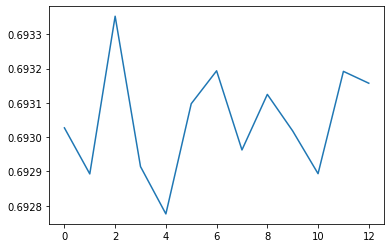

In [ ]:
plt.plot(training_loss[:13])

In [ ]:
model = model.to('cpu')
y_pred = model(torch.tensor(link_features_val)).detach().cpu().softmax(dim = 1)

In [ ]:
roc_auc_score(labels_model_selection, y_pred[:,1].numpy())

(634465, 5888)

In [ ]:
import pytorch_lightning as pl
import math

class MLP(pl.LightningModule):
  def __init__(self, output_dim, input_dim = 128):
    super().__init__()
    self.mlp = torch.nn.Sequential(nn.Linear(input_dim, input_dim),
                                   nn.ReLU(),
                                   nn.Linear(input_dim, output_dim),
                                   nn.ReLU(),
                                   nn.Linear(output_dim,output_dim))
  
  def forward(self, x):
    return self.mlp(x)

class Transformer(pl.LightningModule):
  def __init__(self, output_size):
    super().__init__()
    self.positional = PositionalEncoding(128)
    self.transformer = torch.nn.Transformer(d_model = 128, dropout = 0.1, batch_first = True, 
                                            num_encoder_layers = 3, num_decoder_layers = 3)

  def forward(self, x, y, mask = None):
    if mask != None:
      x1 = self.transformer(self.positional(x), self.positional(y), src_mask = mask[0,:,:], tgt_mask = mask[0,:,:])
    else:
      x1 = self.transformer(self.positional(x), self.positional(y))
    return x1

  def training_step(self, train_batch, batch_idx):
    X, Y, mask = train_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, Y, mask = validation_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y)
    self.log("validation_loss", loss)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    return optimizer

In [ ]:
class PositionalEncoding(pl.LightningModule):
  def __init__(self, d_model, dropout=0.0, max_len=28):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
  
  def forward(self, x):
    x = x + self.pe[:x.size(1), :]
    return self.dropout(x)

In [ ]:
training_set = Dataset(examples_train, labels_train, data)
validation_set = Dataset(examples_model_selection, labels_model_selection, data)
training_generator = torch.utils.data.DataLoader(training_set, shuffle = True, batch_size = 256, num_workers = 4)
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size = 256, num_workers = 4)

model = Transformer(128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='./drive/MyDrive/science4cast/Transformer-2/')

trainer = pl.Trainer(gpus=1, 
                     default_root_dir='./drive/MyDrive/science4cast/Transformer-2/',
                     max_epochs = 20,
                     auto_lr_find='lr',
                     callbacks = [checkpoint_callback])

trainer.fit(model, training_generator, validation_generator)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./drive/MyDrive/science4cast/Transformer-2/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.8 M 
---------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.030    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0eb48dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0eb48dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0eb48dd0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0eb48dd0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d0eb48dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid

In [ ]:
torch.save(model,"./drive/MyDrive/science4cast/transformer-model.pt")

In [ ]:
class LP(pl.LightningModule):
  def __init__(self, transformer, input_size = 28*128, output_dim = 2):
    super().__init__()
    self.transformer = transformer
    self.mlp = MLP(output_dim, input_size)

  def forward(self, x, y, mask = None):
    if mask == None:
      x1 = self.transformer(x,y)
      y = self.mlp(torch.flatten(x1, start_dim = 1))
    return y

  def training_step(self, train_batch, batch_idx):
    X, y = train_batch
    y_pred = self.forward(X,X)
    loss = torch.nn.CrossEntropyLoss()(y_pred, y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, y = validation_batch
    y_pred = self.forward(X,X)
    loss = torch.nn.CrossEntropyLoss()(y_pred, y)
    self.log("validation_loss", loss)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    return optimizer

In [ ]:
lp = LP(model)

In [ ]:
class DatasetLP(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, examples_train, labels_train, data):
        'Initialization'
        self.examples_train = examples_train
        self.data = data
        self.labels = labels_train

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.examples_train)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx1,idx2 = self.examples_train[index]
        X = torch.cat((data[:,idx1,:], data[:,idx2,:]), dim = 0)
        y = self.labels[index]
        return X, y

In [ ]:
training_set = DatasetLP(examples_train, labels_train, data)
validation_set = DatasetLP(examples_model_selection, labels_model_selection, data)
training_generator = torch.utils.data.DataLoader(training_set, shuffle = True, batch_size = 256, num_workers = 4)
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size = 256, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='./drive/MyDrive/science4cast/TransformerLP-2/')

trainer = pl.Trainer(gpus=1, 
                     default_root_dir='./drive/MyDrive/science4cast/TransformerLP-2/',
                     max_epochs = 5,
                     auto_lr_find='lr',
                     callbacks = [checkpoint_callback])

trainer.fit(lp, training_generator, validation_generator)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./drive/MyDrive/science4cast/TransformerLP-2/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params
--------------------------------------------
0 | transformer | Transformer | 3.8 M 
1 | mlp         | MLP         | 12.9 M
--------------------------------------------
16.6 M    Trainable params
0         Non-trainable params
16.6 M    Total params
66.454    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
lp = LP.load_from_checkpoint('/content/drive/MyDrive/science4cast/TransformerLP2/epoch=49-step=702249.ckpt', transformer = model)

In [ ]:
test_set = DatasetLP(unconnected_vertex_pairs, torch.zeros(len(unconnected_vertex_pairs)), data)
test_generator = torch.utils.data.DataLoader(test_set, batch_size = 512, num_workers = 4)

In [ ]:
predictions = torch.zeros(len(unconnected_vertex_pairs), 2)
batch_size = 512
idx = 0
for X, y in tqdm(test_generator):
  predictions[idx*batch_size:(idx+1)*batch_size,:] = lp(X,X)

  0%|          | 8/1954 [00:20<1:35:55,  2.96s/it]

In [ ]:
from tqdm import tqdm

In [ ]:
%%capture
!pip install pytorch-lightning

In [ ]:
%pip install -q stellargraph[demos]==1.2.1

from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)
DRIVE_PATH = "/content/drive/My Drive/science4cast"

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from math import isclose
from scipy import sparse
import networkx as nx
import numpy as np
import pickle
import pandas as pd
import random
import time
from datetime import date
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import stellargraph as sg
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter

import torch
import torch.nn as nn

In [ ]:
NUM_OF_VERTICES=64719 # number of vertices of the semantic net
DRIVE_PATH = "/content/drive/My Drive/science4cast"
data_source = os.path.join(DRIVE_PATH, 'competition_data/CompetitionSet2017_3.pkl')
#data_source = os.path.join(DRIVE_PATH, 'TrainSet2014_3.pkl')
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( data_source, "rb" ) )

print(data_source+' has '+str(len(full_dynamic_graph_sparse))+' edges between a total of '+str(NUM_OF_VERTICES)+ ' vertices.\n\n')
print('The goal is to predict which of '+str(len(unconnected_vertex_pairs))+' unconnectedvertex-pairs\nin unconnected_vertex_pairs will be connected until '+str(year_start+years_delta)+'.')


/content/drive/My Drive/science4cast/competition_data/CompetitionSet2017_3.pkl has 7652945 edges between a total of 64719 vertices.


The goal is to predict which of 1000000 unconnectedvertex-pairs
in unconnected_vertex_pairs will be connected until 2020.


# Helper

In [ ]:
def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    print(years)
    day_origin = date(1990,1,1)
    
    days_curr = (date(year_start,12,31)-day_origin).days
    days_later = (date(year_start+years_delta,12,31)-day_origin).days

    all_G = []

    for days in [days_later, days_curr]:
      all_edges=full_graph[full_graph[:,2]<=days]
      print('    num of edges: ', len(all_edges))
      adj_mat_sparse = sparse.csr_matrix((np.ones(len(all_edges)), (all_edges[:,0], all_edges[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
      all_G.append(nx.from_scipy_sparse_matrix(adj_mat_sparse, parallel_edges=False, create_using=None, edge_attribute='weight'))

    all_degs=np.array(adj_mat_sparse.sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    ## get positive examples
    all_edges_after = full_graph[(days_curr<full_graph[:,2]) & (full_graph[:,2]<=days_later)]
    print(len(all_edges_after))
    all_edges_after = all_edges_after[np.all(np.isin(all_edges_after[:,:2], vertex_large_degs), axis=1)]
    print(len(all_edges_after))

    ## get negative  examples
    unconnected_vertex_pairs=[]

    while len(unconnected_vertex_pairs) < max(edges_used, len(all_edges_after)):        
        v1,v2=np.random.choice(vertex_large_degs, 2)

        if (v1!=v2) and (not all_G[0].has_edge(v1,v2)) and (not all_G[1].has_edge(v1,v2)):
            unconnected_vertex_pairs.append((v1,v2))

    unconnected_vertex_pairs_solution=np.array([1]*len(all_edges_after)+[0]*len(unconnected_vertex_pairs))        
    unconnected_vertex_pairs=np.vstack((all_edges_after[:, :2], np.array(unconnected_vertex_pairs)))
  
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
      
    return np.array(all_edges), unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10

def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection != 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}
   
    return d, Z, tform

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, embedding, binary_operator):
    return binary_operator(embedding[link_examples[:,0]], embedding[link_examples[:,1]])

# 2. training classifier
def train_link_prediction_model(link_examples, link_labels, get_embedding, binary_operator):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=5, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(clf, link_examples_test, link_labels_test, get_embedding, binary_operator):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

def operator_concat(u,v):
    return np.hstack((u,v))


def run_link_prediction(binary_operator, embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
        "embedding": embedding_train,
    }

#binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]
binary_operators = [operator_l2]

# Evaluate

In [ ]:
embeddings = []
year_start = 1994
num_years = 23
for i in range(num_years):
  year = i+year_start
  name = 'node2vec-'+str(year) +'.pkl'
  with open("/content/drive/MyDrive/science4cast/node2vec_embeddings/"+name, "rb") as pickle_file:
    embeddings = embeddings + [pickle.load(pickle_file)]


In [ ]:
aligned_embeddings = []
num_years = 23
for i in range(num_years):
  d,Z,tform = procrustes(embeddings[-1], embeddings[i])
  aligned_embeddings = aligned_embeddings + [Z]

In [ ]:
num_nodes,embed_dim = aligned_embeddings[0].shape
data = torch.zeros(num_years, num_nodes, embed_dim) #torch.tensor(aligned_embeddings[0])
for i in range(num_years):
  data[i,:,:] = torch.tensor(aligned_embeddings[i]) #torch.cat((data,torch.tensor(aligned_embeddings[i])), dim = 1)

In [ ]:
embeddings = 0
aligned_embeddings = 0

In [ ]:
import pytorch_lightning as pl
import math

class MLP(pl.LightningModule):
  def __init__(self, output_dim, input_dim = 128):
    super().__init__()
    self.mlp = torch.nn.Sequential(nn.Linear(input_dim, input_dim),
                                   nn.ReLU(),
                                   nn.Linear(input_dim, output_dim),
                                   nn.ReLU(),
                                   nn.Linear(output_dim,output_dim))
  
  def forward(self, x):
    return self.mlp(x)

class Transformer(pl.LightningModule):
  def __init__(self, output_size):
    super().__init__()
    self.positional = PositionalEncoding(128)
    self.transformer = torch.nn.Transformer(d_model = 128, dropout = 0.1, batch_first = True, 
                                            num_encoder_layers = 3, num_decoder_layers = 3)

  def forward(self, x, y, mask = None):
    if mask != None:
      x1 = self.transformer(self.positional(x), self.positional(y), src_mask = mask[0,:,:], tgt_mask = mask[0,:,:])
    else:
      x1 = self.transformer(self.positional(x), self.positional(y))
    return x1

  def training_step(self, train_batch, batch_idx):
    X, Y, mask = train_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, Y, mask = validation_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y)
    self.log("validation_loss", loss)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    return optimizer

In [ ]:
class PositionalEncoding(pl.LightningModule):
  def __init__(self, d_model, dropout=0.0, max_len=46):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
  
  def forward(self, x):
    x = x + self.pe[:x.size(1), :]
    return self.dropout(x)

In [ ]:
class LP(pl.LightningModule):
  def __init__(self, transformer, input_size = 46*128, output_dim = 2):
    super().__init__()
    self.transformer = transformer
    self.mlp = MLP(output_dim, input_size)

  def forward(self, x, y, mask = None):
    if mask == None:
      x1 = self.transformer(x,y)
      y = self.mlp(torch.flatten(x1, start_dim = 1))
    return y

  def training_step(self, train_batch, batch_idx):
    X, y = train_batch
    y_pred = self.forward(X,X)
    loss = torch.nn.CrossEntropyLoss()(y_pred, y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, y = validation_batch
    y_pred = self.forward(X,X)
    loss = torch.nn.CrossEntropyLoss()(y_pred, y)
    self.log("validation_loss", loss)

  def test_step(self, test_batch, batch_idx):
    X, y = test_batch
    y_pred = self.forward(X,X)
    torch.save(y_pred, "./drive/MyDrive/science4cast/TransformerLP/"+str(batch_idx))
    

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    return optimizer

In [ ]:
class DatasetLP(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, examples_train, labels_train, data):
        'Initialization'
        self.examples_train = examples_train
        self.data = data
        self.labels = labels_train

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.examples_train)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx1,idx2 = self.examples_train[index]
        X = torch.cat((data[:,idx1,:], data[:,idx2,:]), dim = 0)
        y = self.labels[index]
        return X, y

In [ ]:
model = Transformer(128)
lp = LP.load_from_checkpoint('/content/drive/MyDrive/science4cast/TransformerLP2/epoch=49-step=702249.ckpt', transformer = model)

In [ ]:
test_set = DatasetLP(unconnected_vertex_pairs, torch.zeros(len(unconnected_vertex_pairs)), data)
test_generator = torch.utils.data.DataLoader(test_set, batch_size = 512)

In [ ]:
from tqdm import tqdm

In [ ]:
trainer = pl.Trainer(gpus=1)
trainer.test(lp, test_generator)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [ ]:
predictions = torch.zeros(len(unconnected_vertex_pairs), 2)
a = 

In [ ]:
predictions = torch.zeros(len(unconnected_vertex_pairs), 2)
batch_size = 512
for i in range(1954):
  if i < 1953:
    predictions[i*batch_size:(i+1)*batch_size,:] = torch.load("./drive/MyDrive/science4cast/TransformerLP/"+str(i))
  else:
    predictions[i*batch_size:,:] = torch.load("./drive/MyDrive/science4cast/TransformerLP/"+str(i))

In [ ]:
predictions = predictions.softmax(dim = 1)

In [ ]:
all_predictions_eval = predictions[:,1].numpy()

In [ ]:
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))  
year_start = 2017

In [ ]:
import json

if year_start==2017:
    # Save the results for submission.
    submit_file="./drive/MyDrive/science4cast/transformer_all_idx"+str(year_start)+"_"+str(years_delta)+".json"
    all_idx_list_float=list(map(float, sorted_predictions_eval))
    with open(submit_file, "w", encoding="utf8") as json_file:
        json.dump(all_idx_list_float, json_file)
    
    print("Solution stored as "+submit_file+".\nLooking forward to your submission.")  

Solution stored as ./drive/MyDrive/science4cast/transformer_all_idx2017_3.json.
Looking forward to your submission.
